# Tutorial on self-normalizing networks on the MNIST data set: convolutional neural networks

*Author:* Guenter Klambauer, 2017

tested under Python 3.5 and Tensorflow 1.1


In [1]:
import tensorflow as tf
import numpy as np

from __future__ import absolute_import, division, print_function
import numbers
from tensorflow.contrib import layers
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.framework import tensor_util
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import random_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.layers import utils

from sklearn.preprocessing import StandardScaler
from scipy.special import erf,erfc

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


### (1) Definition of scaled exponential linear units (SELUs)

In [2]:
def selu(x):
    with ops.name_scope('elu') as scope:
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        return scale*tf.where(x>=0.0, x, alpha*tf.nn.elu(x))

### (2) Definition of dropout variant for SNNs


In [3]:

def dropout_selu(x, rate, alpha=-1.7580993408473766, noise_shape=None, seed=None, name=None, training=False):
    """Dropout to a value with rescaling."""

    def dropout_selu_impl(x, rate, alpha, noise_shape, seed, name):
        keep_prob = 1.0 - rate
        x = ops.convert_to_tensor(x, name="x")
        if isinstance(keep_prob, numbers.Real) and not 0 < keep_prob <= 1:
            raise ValueError("keep_prob must be a scalar tensor or a float in the "
                                             "range (0, 1], got %g" % keep_prob)
        keep_prob = ops.convert_to_tensor(keep_prob, dtype=x.dtype, name="keep_prob")
        keep_prob.get_shape().assert_is_compatible_with(tensor_shape.scalar())

        alpha = ops.convert_to_tensor(alpha, dtype=x.dtype, name="alpha")
        keep_prob.get_shape().assert_is_compatible_with(tensor_shape.scalar())

        # Do nothing if we know keep_prob == 1
        if tensor_util.constant_value(keep_prob) == 1:
            return x

        noise_shape = noise_shape if noise_shape is not None else array_ops.shape(x)
        # uniform [keep_prob, 1.0 + keep_prob)
        random_tensor = keep_prob
        random_tensor += random_ops.random_uniform(noise_shape, seed=seed, dtype=x.dtype)
        # 0. if [keep_prob, 1.0) and 1. if [1.0, 1.0 + keep_prob)
        binary_tensor = math_ops.floor(random_tensor)
        #binary_tensor2 = math_ops.ceil(random_tensor)
        ret = x * binary_tensor + alpha * (1-binary_tensor)

        #a = tf.sqrt(1.0/(keep_prob+alpha^2*keep_prob*(1.0-keep_prob)))
        a = tf.sqrt(1.0 / keep_prob + tf.pow(alpha,2) * keep_prob * 1.0 - keep_prob)
        #a = tf.sqrt(tf.div(1.0, tf.add(keep_prob ,tf.multiply(tf.pow(alpha,2) , tf.multiply(keep_prob,    tf.subtract(1.0,keep_prob)))) ))

        b = -a * (1 - keep_prob) * alpha
        #b = tf.neg( tf.mul(a , (tf.multiply(tf.subtract(1.0,keep_prob),alpha))))
        ret = a * ret + b
        #ret = tf.add(tf.multiply(a , ret) , b)
        ret.set_shape(x.get_shape())
        return ret

    with ops.name_scope(name, "dropout", [x]) as name:
        return utils.smart_cond(training,
            lambda: dropout_selu_impl(x, rate, alpha, noise_shape, seed, name),
            lambda: array_ops.identity(x))

### (3) Scale input to zero mean and unit variance

In [4]:
scaler = StandardScaler().fit(mnist.train.images)

In [5]:
# Parameters
learning_rate = 0.025
training_iters = 50
batch_size = 128
display_step = 1

# Network Parameters
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
keep_prob_ReLU = 0.75 # Dropout, probability to keep units
dropout_prob_SNN = 0.05 # Dropout, probability to dropout units

# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability for ReLU)
dropout_prob =  tf.placeholder(tf.float32) #dropout (dropout probability for SNN)

In [6]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def conv2d_SNN(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return selu(x)

def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

In [7]:
# Create model
def conv_net_ReLU(x, weights, biases, keep_prob):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [8]:
# Create model
def conv_net_SNN(x, weights, biases, dropout_prob):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d_SNN(x, weights['wc1'], biases['bc1'],)
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d_SNN(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = selu(fc1)
    
    # Apply Dropout
    fc1 = dropout_selu(fc1, dropout_prob)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [9]:
# RELU: Store layers weight & bias
## Improved with MSRA initialization

weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32],stddev=np.sqrt(2/25)) ),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64],stddev=np.sqrt(2/(25*32)))),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024],stddev=np.sqrt(2/(7*7*64)))),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes],stddev=np.sqrt(2/(1024))))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32],stddev=0)),
    'bc2': tf.Variable(tf.random_normal([64],stddev=0)),
    'bd1': tf.Variable(tf.random_normal([1024],stddev=0)),
    'out': tf.Variable(tf.random_normal([n_classes],stddev=0))
}

### (4) Initialization with STDDEV of sqrt(1/n)

In [10]:
# SNN: Store layers weight & bias
weights2 = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32],stddev=np.sqrt(1/25)) ),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64],stddev=np.sqrt(1/(25*32)))),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024],stddev=np.sqrt(1/(7*7*64)))),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes],stddev=np.sqrt(1/(1024))))
}

biases2 = {
    'bc1': tf.Variable(tf.random_normal([32],stddev=0)),
    'bc2': tf.Variable(tf.random_normal([64],stddev=0)),
    'bd1': tf.Variable(tf.random_normal([1024],stddev=0)),
    'out': tf.Variable(tf.random_normal([n_classes],stddev=0))
}


In [11]:
# Construct model
pred_ReLU = conv_net_ReLU(x, weights, biases, keep_prob)
pred_SNN = conv_net_SNN(x, weights2, biases2, dropout_prob)

# Define loss and optimizer
cost_ReLU = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred_ReLU, labels=y))
cost_SNN = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred_SNN, labels=y))

optimizer_ReLU = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_ReLU)
optimizer_SNN = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_SNN)

# Evaluate ReLU model
correct_pred_ReLU = tf.equal(tf.argmax(pred_ReLU, 1), tf.argmax(y, 1))
accuracy_ReLU = tf.reduce_mean(tf.cast(correct_pred_ReLU, tf.float32))

# Evaluate SNN model
correct_pred_SNN = tf.equal(tf.argmax(pred_SNN, 1), tf.argmax(y, 1))
accuracy_SNN = tf.reduce_mean(tf.cast(correct_pred_SNN, tf.float32))


# Initializing the variables
init = tf.global_variables_initializer()

In [12]:
training_loss_protocol_ReLU = []
training_loss_protocol_SNN = []

In [13]:
# Launch the graph
gpu_options = tf.GPUOptions(allow_growth=True)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    step = 0
    # Keep training until reach max iterations
    while step < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        batch_x_norm = scaler.transform(batch_x)
        # Run optimization op (backprop)
        sess.run(optimizer_ReLU, feed_dict={x: batch_x, y: batch_y,
                                       keep_prob: keep_prob_ReLU})
        sess.run(optimizer_SNN, feed_dict={x: batch_x_norm, y: batch_y,
                                       dropout_prob: dropout_prob_SNN})
        
        
        if step % display_step == 0:
            #batch_x, batch_y = mnist.test.next_batch(batch_size)
            #batch_x_norm = scaler.transform(batch_x)
            # Calculate batch loss and accuracy
            loss_ReLU, acc_ReLU = sess.run([cost_ReLU, accuracy_ReLU], feed_dict={x: batch_x,
                                                              y: batch_y,
                                                              keep_prob: 1.0})
            training_loss_protocol_ReLU.append(loss_ReLU)
            
            loss_SNN, acc_SNN = sess.run([cost_SNN, accuracy_SNN], feed_dict={x: batch_x_norm,
                                                              y: batch_y,
                                                              dropout_prob: 0.0})
            training_loss_protocol_SNN.append(loss_SNN)
            
            print( "RELU: Nbr of updates: " + str(step+1) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss_ReLU) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc_ReLU))
            
            print( "SNN: Nbr of updates: " + str(step+1) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss_SNN) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc_SNN))
        step += 1
    print("Optimization Finished!\n")

    # Calculate accuracy for 256 mnist test images
    print("ReLU: Testing Accuracy:", sess.run(accuracy_ReLU, feed_dict={x: mnist.test.images[:512],
                                      y: mnist.test.labels[:512],
                                      keep_prob: 1.0}))
    print("SNN: Testing Accuracy:", sess.run(accuracy_SNN, feed_dict={x: scaler.transform(mnist.test.images[:512]),
                                      y: mnist.test.labels[:512],
                                      dropout_prob: 0.0}))

RELU: Nbr of updates: 1, Minibatch Loss= 2.242543, Training Accuracy= 0.18750
SNN: Nbr of updates: 1, Minibatch Loss= 2.410042, Training Accuracy= 0.54688
RELU: Nbr of updates: 2, Minibatch Loss= 1.947377, Training Accuracy= 0.44531
SNN: Nbr of updates: 2, Minibatch Loss= 2.102875, Training Accuracy= 0.44531
RELU: Nbr of updates: 3, Minibatch Loss= 1.653256, Training Accuracy= 0.32031
SNN: Nbr of updates: 3, Minibatch Loss= 1.900189, Training Accuracy= 0.63281
RELU: Nbr of updates: 4, Minibatch Loss= 1.863521, Training Accuracy= 0.42969
SNN: Nbr of updates: 4, Minibatch Loss= 1.043929, Training Accuracy= 0.69531
RELU: Nbr of updates: 5, Minibatch Loss= 1.607563, Training Accuracy= 0.56250
SNN: Nbr of updates: 5, Minibatch Loss= 0.610884, Training Accuracy= 0.80469
RELU: Nbr of updates: 6, Minibatch Loss= 1.448746, Training Accuracy= 0.67188
SNN: Nbr of updates: 6, Minibatch Loss= 0.472937, Training Accuracy= 0.87500
RELU: Nbr of updates: 7, Minibatch Loss= 1.318685, Training Accuracy= 

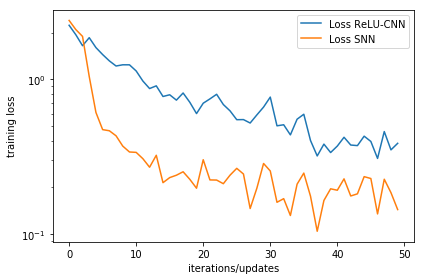

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot( training_loss_protocol_ReLU, label='Loss ReLU-CNN')
ax.plot( training_loss_protocol_SNN, label='Loss SNN')
ax.set_yscale('log')  # log scale
ax.set_xlabel('iterations/updates')
ax.set_ylabel('training loss')
fig.tight_layout()
ax.legend()
fig